In [2]:
import pandas as pd
import numpy as np
import cv2,os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [3]:
import pathlib

In [4]:
label_dict={"no_tumor":0,"glioma_tumor":1,"meningioma_tumor":2,"pituitary_tumor":3}
categories=["no_tumor","glioma_tumor","meningioma_tumor","pituitary_tumor"]
labels=[0,1,2,3]

In [5]:
train_data_path="btd_class/Training"
test_data_path="btd_class/Testing"
data_dir = "btd_class/Training"
data_dir=pathlib.Path(data_dir)

In [65]:
train_d,test_x=[],[]
train_t,test_y=[],[]

In [6]:
for category in categories:
    folder_path=os.path.join(train_data_path,category)
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try:
            resized=cv2.resize(img,(150,150))
            train_d.append(resized)
            train_t.append(label_dict[category])
        except Exception as e:
            pass

In [66]:
for category in categories:
    folder_path=os.path.join(test_data_path,category)
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try: 
            resized=cv2.resize(img,(150,150))
            test_x.append(resized)
            test_y.append(label_dict[category])
        except Exception as e:
            pass

In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_path,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(200, 200),
  batch_size=32)

Found 2870 files belonging to 4 classes.
Using 287 files for validation.


In [64]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_path
  validation_split=0.1,dtype="float32",
  subset="training",
  seed=123,
  image_size=(200, 200),
  batch_size=32)

Found 2870 files belonging to 4 classes.
Using 2583 files for training.


In [45]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_path,
  seed=123,
  image_size=(200, 200),
  batch_size=32)

Found 394 files belonging to 4 classes.


In [33]:
train_x=np.array(train_d)

In [34]:
train_x=train_x/255
train_x.shape

(2870, 200, 200, 3)

In [67]:
test_x=np.array(test_x)

In [68]:
test_x=test_x/255
test_x.shape

(394, 150, 150, 3)

val_x=np.array(val_x)

val_x.shape

In [37]:
train_y=np.array(train_t)
train_y.shape

(2870,)

In [38]:
new_train_y=to_categorical(train_y) #Converting the target into categorical data
new_train_y.shape

(2870, 4)

In [69]:
test_y=np.array(test_y)
test_y.shape

(394,)

In [70]:
new_test_y=to_categorical(test_y) #Converting the target into categorical data
new_test_y.shape

(394, 4)

val_y=np.array(val_y)
new_val_y=to_categorical(val_y)
new_val_y.shape

In [44]:
train_ds.take(1)

<TakeDataset shapes: ((None, 200, 200, 1), (None,)), types: (tf.float32, tf.int32)>

In [32]:
import matplotlib.pyplot as plt

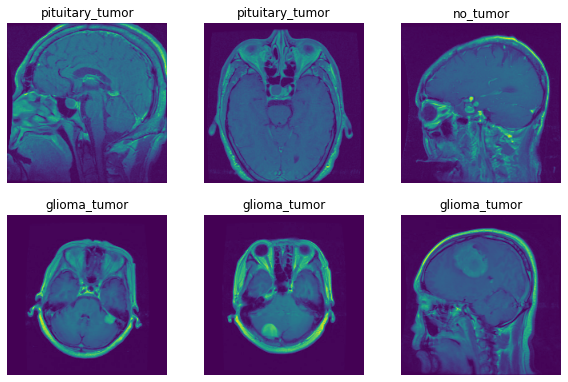

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(categories[labels[i]])
        plt.axis("off")

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [65]:
resnet50_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet50_model.add(pretrained_model)

In [66]:
resnet50_model.add(Flatten())
resnet50_model.add(Dense(512, activation='relu'))
resnet50_model.add(Dense(5, activation='softmax'))

In [67]:
resnet50_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23581440  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 24,633,093
Trainable params: 1,051,653
Non-trainable params: 23,581,440
_________________________________________________________________


In [ ]:
resnet50_model.compile(optimizer=Adam(lr=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet50_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
81/81 [==============================] - 374s 5s/step - loss: 1.6058 - accuracy: 0.3151 - val_loss: 1.3359 - val_accuracy: 0.3868
Epoch 2/10
81/81 [==============================] - 368s 5s/step - loss: 1.3378 - accuracy: 0.3767 - val_loss: 1.3326 - val_accuracy: 0.2962
Epoch 3/10
60/81 [=====================>........] - ETA: 1:24 - loss: 1.3318 - accuracy: 0.3505

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.3,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=6)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
#import cv2
#img,label=train_ds.take(1)
#image=cv2.imread(str(img))
#image_resized= cv2.resize(image, (200,200))
#image=np.expand_dims(image_resized,axis=0)

In [ ]:
resnet50_model.evaluate(test_ds)

In [ ]:
pred=resnet50_model.predict(test_ds)

In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

In [56]:
Inception_model = Sequential()

pretrained_model= tf.keras.applications.InceptionResNetV2(include_top=False,
                   input_shape=(200,200,1),
                   pooling='max',classes=4,
                   weights=None)
for layer in pretrained_model.layers:
        layer.trainable=False

Inception_model.add(pretrained_model)

In [57]:
Inception_model.add(Flatten())
Inception_model.add(Dense(512, activation='relu'))
Inception_model.add(Dense(5, activation='softmax'))

In [58]:
Inception_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336160  
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 55,125,669
Trainable params: 789,509
Non-trainable params: 54,336,160
_________________________________________________________________


In [ ]:
Inception_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history1 = Inception_model.fit(train_ds, validation_data=val_ds, epochs=10)

In [ ]:
fig3 = plt.gcf()
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.axis(ymin=0.3,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
fig4 = plt.gcf()
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.axis(ymin=0,ymax=6)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
Inception_model.evaluate(test_ds)

In [ ]:
pred1=Inception_model.predict(test_ds)

In [ ]:
output_class1=class_names[np.argmax(pred1)]
print("The predicted class is", output_class1)

In [8]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
Conv_Base = ResNet50(include_top = False, weights = 'imagenet', input_shape = (150,150, 3))

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 4, activation = 'softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 1028      
Total params: 36,696,196
Trainable params: 16,524,036
Non-trainable params: 20,172,160
_________________________________________________________________


In [40]:
batch_size = 48

Train_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input,validation_split=0.2)
Val_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input,validation_split=0.2)

train_gen = Train_Datagen.flow_from_directory(directory = train_data_path, target_size = (150,150), 
                                       batch_size = batch_size, class_mode = 'categorical',subset="training")

val_gen = Val_Datagen.flow_from_directory(directory = train_data_path, target_size = (150,150), 
                                       batch_size = batch_size, class_mode = 'categorical',subset="validation")

epochs = 10
Number_Of_Training_Images = train_gen.classes.shape[0]
steps_per_epoch = Number_Of_Training_Images/batch_size

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_gen, epochs = epochs, 
                    #batch_size = batch_size,
                    validation_data = val_gen, steps_per_epoch = steps_per_epoch)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Epoch 1/10
48/47 [==============================] - 208s 4s/step - loss: 22.8075 - accuracy: 0.7501 - val_loss: 2.3479 - val_accuracy: 0.7574
Epoch 2/10
48/47 [==============================] - 207s 4s/step - loss: 0.6895 - accuracy: 0.8742 - val_loss: 0.9193 - val_accuracy: 0.7836
Epoch 3/10
48/47 [==============================] - 204s 4s/step - loss: 0.3050 - accuracy: 0.8977 - val_loss: 1.0512 - val_accuracy: 0.7714
Epoch 4/10
48/47 [==============================] - 204s 4s/step - loss: 0.2035 - accuracy: 0.9316 - val_loss: 1.0500 - val_accuracy: 0.8168
Epoch 5/10
48/47 [==============================] - 209s 4s/step - loss: 0.1656 - accuracy: 0.9451 - val_loss: 1.0793 - val_accuracy: 0.8307
Epoch 6/10
48/47 [==============================] - 209s 4s/step - loss: 0.1220 - accuracy: 0.9591 - val_loss: 1.2177 - val_accuracy: 0.8482
Epoch 7/10
48/47 [==============================] - 204s 4s/step - los

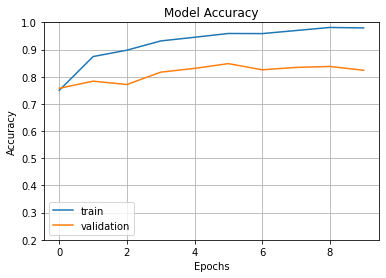

In [41]:
fig3 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('ResNet50Acc.png')
plt.legend(['train', 'validation'])
plt.show()

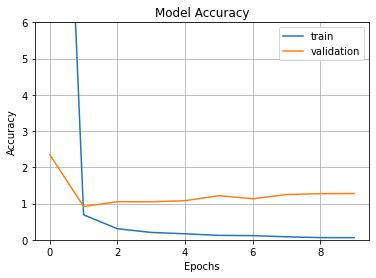

In [42]:
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=6)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('ResNet50Loss.png')
plt.show()

In [81]:
model.evaluate(test_x)

13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [77]:
y_pred = model.predict(test_x)

NameError: name 'new_test_x' is not defined

In [73]:
y_pred=np.argmax(y_pred,axis=1)

In [75]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve

In [79]:
print(classification_report(y_pred,test_y))
print(confusion_matrix(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.29      0.45       394
           3       0.00      0.00      0.00         0

    accuracy                           0.29       394
   macro avg       0.25      0.07      0.11       394
weighted avg       1.00      0.29      0.45       394

[[  0   0   0   0]
 [  0   0   0   0]
 [105 100 115  74]
 [  0   0   0   0]]
